In [15]:
import h5py

# f_sim = h5py.File("/home/memmelma/Projects/robotic/gifs_curobo/blue_cube_1_128_abs_joint_vis_aug.hdf5", "r", swmr=True)
f_sim = h5py.File("/home/memmelma/Projects/robotic/gifs_curobo/blue_cube_1_128_abs_joint_no_vis_aug.hdf5", "r", swmr=True)
data_sim = f_sim["data"]["demo_0"]

f_real = h5py.File("/home/memmelma/Projects/robotic/debug.hdf5", "r", swmr=True)
data_real = f_real["data"]["demo_0"]

In [16]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

### joints

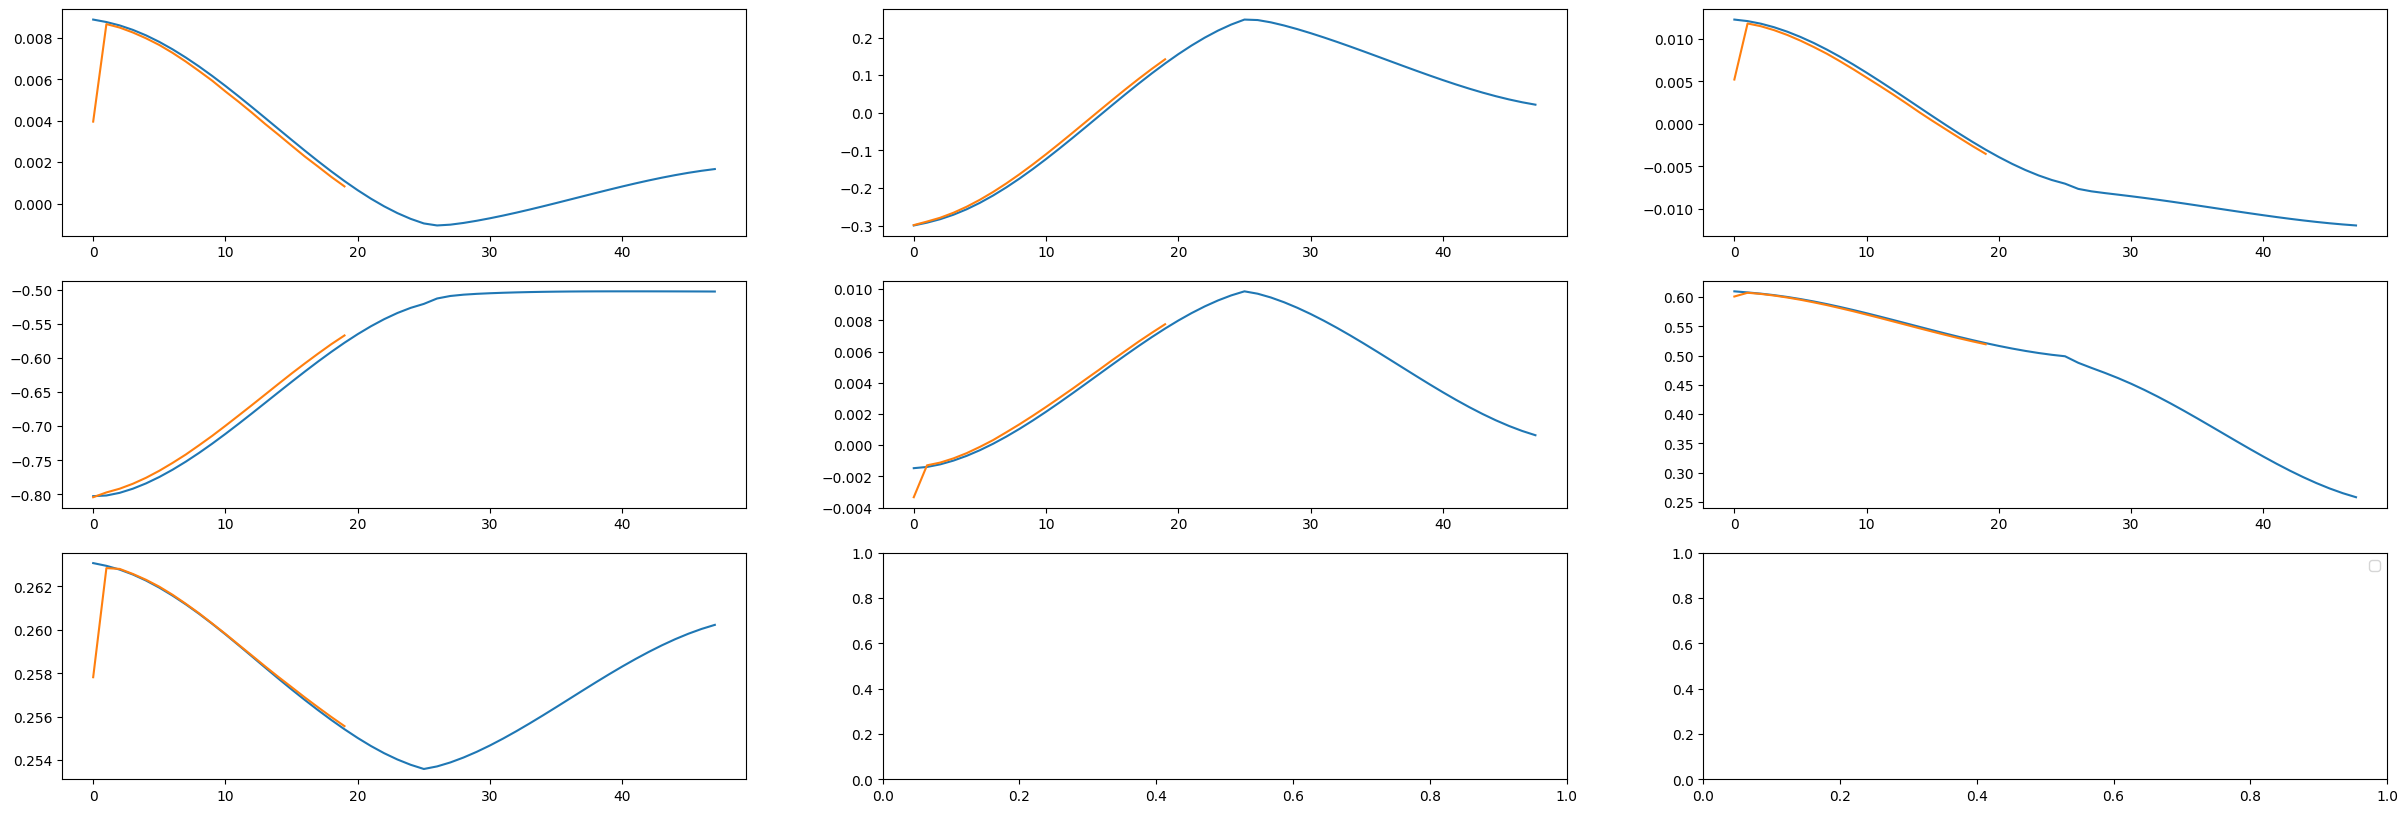

In [17]:
qpos_sim, qpos_real = data_sim["obs"]["qpos_normalized"], data_real["obs"]["qpos_normalized"]
qpos_sim.shape, qpos_real.shape

fig, axs = plt.subplots((qpos_sim.shape[1] // 3) + 1, 3, figsize=(30,10))
for i in range(qpos_sim.shape[1]):
    axs[i//3, i%3].plot(qpos_sim[:,i])
    axs[i//3, i%3].plot(qpos_real[:,i])
plt.legend(["sim", "real"])
plt.show()


### images

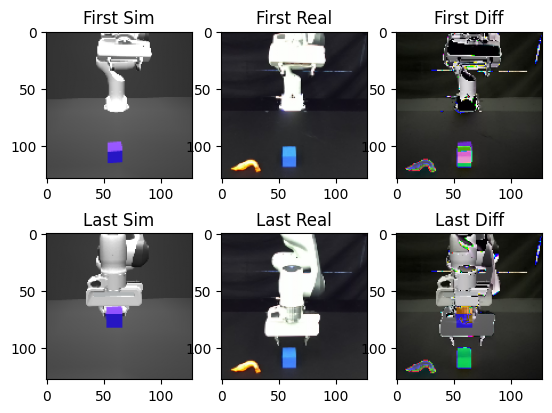

In [18]:
first_sim, last_sim = data_sim["obs"]["rgb"][0], data_sim["obs"]["rgb"][-1]
first_real, last_real = data_real["obs"]["rgb"][0].astype(np.uint8), data_real["obs"]["rgb"][-1].astype(np.uint8)
first_diff = np.abs(first_sim - first_real)
last_diff = np.abs(last_sim - last_real)

plt.subplot(2, 3, 1)
plt.imshow(first_sim / 255.)
plt.title('First Sim')
plt.subplot(2, 3, 2)
plt.imshow(first_real / 255.)
plt.title('First Real')
plt.subplot(2, 3, 3)
plt.imshow(first_diff / 255.)
plt.title('First Diff')
plt.subplot(2, 3, 4)
plt.imshow(last_sim / 255.)
plt.title('Last Sim')
plt.subplot(2, 3, 5)
plt.imshow(last_real / 255.)
plt.title('Last Real')
plt.subplot(2, 3, 6)
plt.imshow(last_diff / 255.)
plt.title('Last Diff')
plt.show()


### clip features

In [5]:
import torch
import clip

model, preprocess = clip.load("RN50")

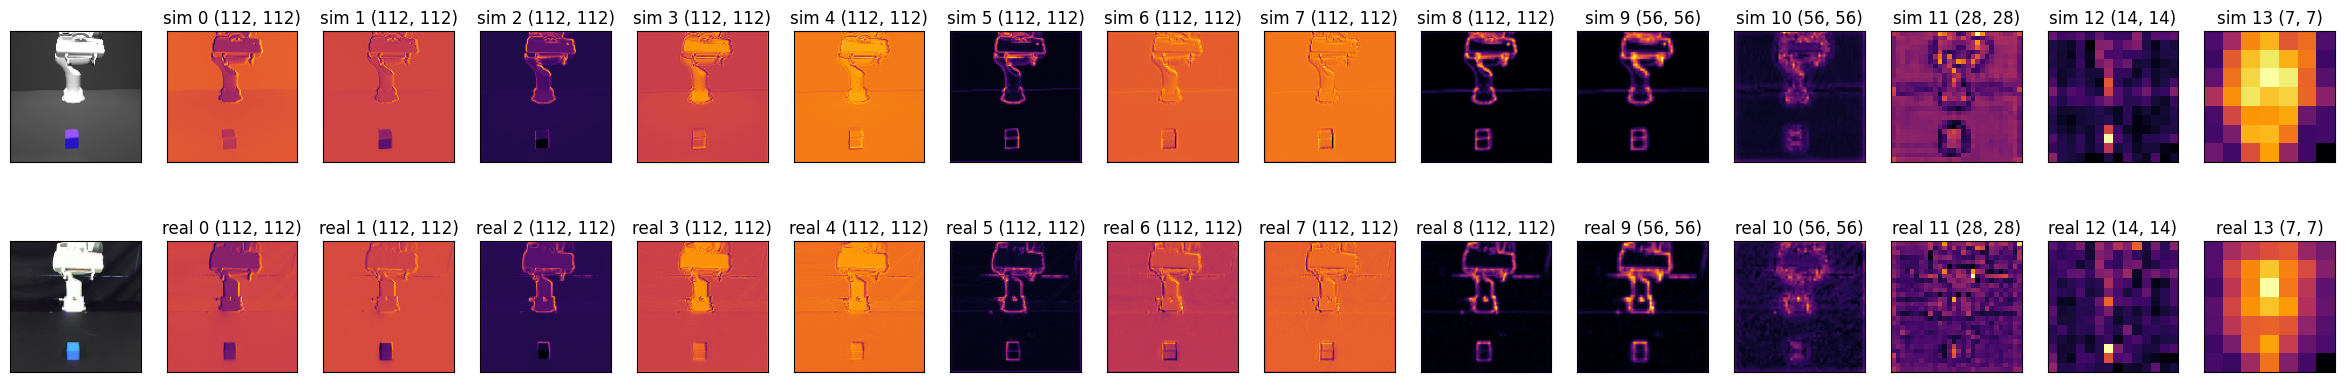

In [6]:

def extract_features(image):
    feats = []
    with torch.no_grad():
        # Forward through visual layers only
        x = image
        for layer in model.visual.children():
            x = layer(x)
            if len(x.shape) == 4:
                feat = x.cpu().numpy()
                feats.append(feat.squeeze(0).mean(0))
    return feats

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_sim = preprocess(Image.fromarray(first_sim)).unsqueeze(0).to(device).half()
feats_sim = extract_features(img_sim)
img_real = preprocess(Image.fromarray(first_real)).unsqueeze(0).to(device).half()
feats_real = extract_features(img_real)

# subplot with sim features in the top row and real features in the bottom row
fig, axs = plt.subplots(2, len(feats_sim) + 1, figsize=(30, 5))
for i, (feat_sim, feat_real) in enumerate(zip(feats_sim, feats_real)):
    axs[0,i+1].imshow(feat_sim, cmap='inferno')
    axs[1, i+1].imshow(feat_real, cmap='inferno')
    axs[0,i+1].set_xticks([])
    axs[0,i+1].set_yticks([])
    axs[1, i+1].set_xticks([])
    axs[1, i+1].set_yticks([])
    axs[0,i+1].set_title(f"sim {i} {feat_sim.shape}")
    axs[1, i+1].set_title(f"real {i} {feat_real.shape}")
axs[0, 0].imshow(first_sim / 255.)
axs[1, 0].imshow(first_real / 255.)
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
plt.show()


### points

In [8]:
from utils.pointclouds import depth_to_points
obs_sim = data_sim["obs"]
B, H, W = obs_sim["depth"].shape
points_sim = depth_to_points(obs_sim["depth"][0].reshape(H, W), obs_sim["camera_intrinsic"][0].reshape(3, 3), obs_sim["camera_extrinsic"][0].reshape(4, 4), depth_scale=1000.)
points_sim = points_sim.reshape(H, W, 3)
colors_sim = obs_sim["rgb"][0].reshape(H, W, 3)

obs_real = data_real["obs"]
import cv2
crop_size = 128
points_real = depth_to_points(obs_real["depth"][0], obs_real["camera_intrinsic"][0].reshape(3, 3), obs_real["camera_extrinsic"][0].reshape(4, 4), depth_scale=1000.)

# points_real = cv2.resize(points_real.reshape(480, 480, 3), (crop_size,crop_size), interpolation=cv2.INTER_NEAREST).reshape(-1, 3)
points_real = points_real.reshape(H, W, 3)
colors_real = obs_real["rgb"][0].reshape(H, W, 3)

assert points_sim.shape == points_real.shape, f"{points_sim.shape} != {points_real.shape}"
assert colors_sim.shape == colors_real.shape, f"{colors_sim.shape} != {colors_real.shape}"

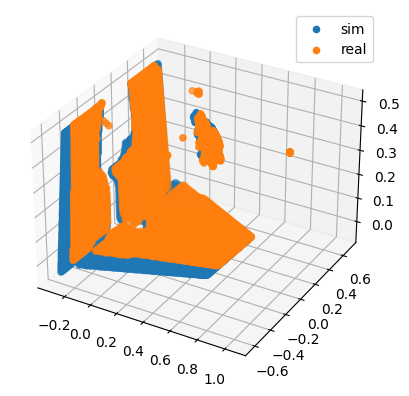

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_sim[:,:,0], points_sim[:,:,1], points_sim[:,:,2], label="sim")#, c=colors_sim.reshape(-1, 3) / 255.)
ax.scatter(points_real[:,:,0], points_real[:,:,1], points_real[:,:,2], label="real")#, c=colors_real.reshape(-1, 3) / 255.)
plt.legend()
plt.show()

In [10]:
from utils.meshcat import create_visualizer, visualize_pointcloud
vis = create_visualizer()

visualize_pointcloud(vis, "sim", points_sim, np.ones_like(points_sim) * np.array([255, 0, 0])) # colors_sim)
visualize_pointcloud(vis, "real", points_real, np.ones_like(points_real) * np.array([0, 255, 0])) # colors_real)


Waiting for meshcat server... have you started a server? Run `meshcat-server` to start a server


KeyboardInterrupt: 

In [4]:
# save using imageio
import imageio
import numpy as np
from PIL import Image

# Get all demos
demos = list(f["data"].keys())
n_demos = len(demos)

# Calculate grid dimensions - make it as square as possible
grid_size = int(np.ceil(np.sqrt(n_demos)))
rows = 4 # grid_size
cols = 7 # grid_size

# Get max sequence length
max_len = max(f["data"][dk]["obs"]["rgb"].shape[0] for dk in demos)

# Create padded grid of videos
grid_videos = []
for i in range(rows):
    row_videos = []
    for j in range(cols):
        idx = i * cols + j
        if idx < n_demos:
            # Get video and pad with last frame
            imgs = f["data"][demos[idx]]["obs"]["rgb"][:]
            pad_len = max_len - len(imgs)
            if pad_len > 0:
                pad_frames = np.repeat(imgs[-1:], pad_len, axis=0)
                imgs = np.concatenate([imgs, pad_frames])
            row_videos.append(imgs)
        else:
            # Pad empty grid spots with black frames
            row_videos.append(np.zeros((max_len, 480, 480, 3), dtype=np.uint8))
    grid_videos.append(row_videos)

# Combine into grid for each timestep
grid_frames = []
for t in range(max_len):
    rows_t = []
    for i in range(rows):
        row_t = np.concatenate([grid_videos[i][j][t] for j in range(cols)], axis=1)
        rows_t.append(row_t)
    grid_t = np.concatenate(rows_t, axis=0)
    # Resize frame to 960x960
    grid_t = Image.fromarray(grid_t).resize((grid_t.shape[1] // 4, grid_t.shape[0] // 4))
    grid_frames.append(np.array(grid_t))

# Save grid video
imageio.mimsave("grid_video.gif", grid_frames)

In [10]:
import os

# load gifs from gif_path and save them as a grid video
gif_path = "/home/memmelma/Projects/robotic/gifs_curobo"

gifs = os.listdir(gif_path)
gifs = [gif for gif in gifs if gif.endswith(".gif")]

# load gifs and save them as a grid video
grid_videos = []
for gif in gifs:
    grid_videos.append(imageio.mimread(os.path.join(gif_path, gif))[0][...,:3])

grid_videos = np.concatenate(grid_videos, axis=1)
# save grid video
imageio.mimsave("grid_video.gif", grid_videos)

ValueError: Image data must be a sequence of ndimages.

In [ ]:
import torch
data = torch.load("episode_0.npz")

{'obs': [{'joint_pos': tensor([[-0.1904, -0.4757,  0.1734, -2.4948,  0.0880,  2.0237,  0.7130,  1.0000]],
          device='cuda:0'),
   'ee_pose': tensor([[ 4.0001e-01, -6.7952e-06,  4.5000e-01, -1.8135e-06,  1.0000e+00,
            -1.0703e-03, -9.8888e-06,  1.0000e+00]], device='cuda:0'),
   'robot_link_pose': tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
             -1.0237e-09,  1.0237e-09],
            [-2.9216e-08, -2.5424e-10,  3.3300e-01,  9.9547e-01, -5.9605e-08,
              2.2352e-08, -9.5046e-02],
            [-2.9216e-08, -2.5424e-10,  3.3300e-01,  6.6825e-01, -6.9992e-01,
             -1.0053e-01, -2.3116e-01],
            [-1.4210e-01,  2.7385e-02,  6.1392e-01,  9.7181e-01, -4.2618e-02,
             -2.3173e-01, -8.2586e-03],
            [-6.8472e-02,  2.7690e-02,  6.5113e-01,  3.7778e-01,  3.6970e-01,
              5.6905e-01, -6.2991e-01],
            [ 3.1226e-01,  6.5426e-03,  5.5701e-01,  5.2994e-01,  3.1574e-02,
              8.4722

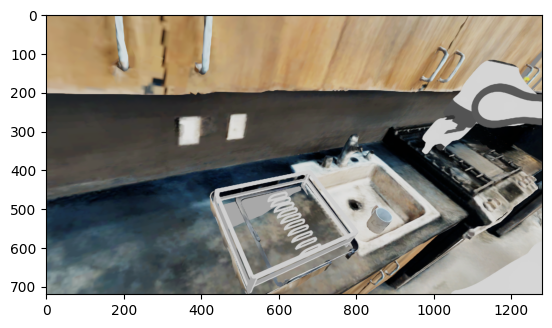

In [39]:
img = data["obs"][0]["rgb"].cpu().numpy()[0,0]
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()


In [27]:
import pickle
pkl_data = pickle.loads(data["episode_0/data.pkl"])

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [20]:
import numpy as np
import pickle

# Load the npz
data = np.load("episode_0.npz", allow_pickle=True)

# Access the pickle inside (as bytes) and load it
pkl_bytes = data["episode_0/data.pkl"].item()  # .item() needed if it's an object array
pkl_data = pickle.loads(pkl_bytes)

# Access some array frame
frame_0 = data["episode_0/data/0"]

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.